# Server Load Balancing - Pipeline Test

This notebook demonstrates the Server Load (M/M/k queueing) environment with two agents:
- **LinUCB**: Contextual bandit with UCB exploration
- **DQN**: Deep Q-Network with experience replay

We compare their learning curves and performance metrics.

In [14]:
import sys
import os

# Add src to path
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [15]:
# Import our modules
from src.envs import ServerLoadEnv, ServerLoadConfig
from src.agents import LinUCBAgent, DQNAgent
from src.utils.seeding import set_global_seeds

print("Imports successful!")

Imports successful!


## 1. Environment Setup

Configure the M/M/k queueing environment with:
- 4 servers
- Arrival rate λ = 10 jobs/sec
- Service rate μ = 3 jobs/sec per server

In [16]:
# Environment configuration
config = ServerLoadConfig(
    num_servers=4,
    arrival_rate=10.0,
    service_rate=3.0,
    max_queue_size=50,
    step_duration=1.0,
    alpha=1.0,   # Latency penalty
    beta=10.0,   # Drop penalty
    gamma=0.1,   # Server cost
)

# Create environment
env = ServerLoadEnv(config=config, seed=42)
state = env.reset()

print(f"State dimension: {len(state)}")
print(f"Action space: {env.action_space.n} servers")
print(f"\nInitial state: {state}")

State dimension: 10
Action space: 4 servers

Initial state: [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0. ]


In [17]:
# Visualize environment
env.render()

Time: 0.00s
  Server 0: [IDLE] Queue: 0/50
  Server 1: [IDLE] Queue: 0/50
  Server 2: [IDLE] Queue: 0/50
  Server 3: [IDLE] Queue: 0/50
  Total Drops: 0


## 2. Training Function

Generic training loop that works with any agent.

In [18]:
def train_agent(agent, env, n_episodes=200, max_steps=100, seed=42):
    """
    Train an agent on the environment.
    
    Returns:
        dict with training history
    """
    set_global_seeds(seed)
    env.reset(seed=seed)
    
    history = {
        'episode_rewards': [],
        'episode_lengths': [],
        'avg_latencies': [],
        'total_drops': [],
        'queue_lengths': [],
    }
    
    for episode in range(n_episodes):
        state = env.reset()
        episode_reward = 0
        episode_latencies = []
        episode_queue_lengths = []
        
        for step in range(max_steps):
            # Select action
            action = agent.select_action(state)
            
            # Take step
            next_state, reward, done, info = env.step(action)
            
            # Store transition
            agent.store(state, action, reward, next_state, done)
            
            # Train if ready
            if agent.ready_to_train():
                agent.update()
            
            # Track metrics
            episode_reward += reward
            if info.get('avg_latency', 0) > 0:
                episode_latencies.append(info['avg_latency'])
            episode_queue_lengths.append(np.mean(info['queue_lengths']))
            
            state = next_state
            if done:
                break
        
        # Record episode stats
        history['episode_rewards'].append(episode_reward)
        history['episode_lengths'].append(step + 1)
        history['avg_latencies'].append(
            np.mean(episode_latencies) if episode_latencies else 0
        )
        history['total_drops'].append(env.total_drops)
        history['queue_lengths'].append(np.mean(episode_queue_lengths))
        
        # Progress update
        if (episode + 1) % 50 == 0:
            avg_r = np.mean(history['episode_rewards'][-50:])
            print(f"Episode {episode+1:4d} | Avg Reward: {avg_r:8.2f}")
    
    return history

## 3. Random Baseline

First, establish a random baseline for comparison.

In [19]:
class RandomAgent:
    """Random action baseline agent."""
    def __init__(self, n_actions):
        self.n_actions = n_actions
    
    def select_action(self, state):
        return np.random.randint(0, self.n_actions)
    
    def store(self, *args):
        pass
    
    def ready_to_train(self):
        return False
    
    def update(self):
        return {}

# Train random baseline
print("Training Random Baseline...")
random_agent = RandomAgent(n_actions=4)
random_history = train_agent(random_agent, env, n_episodes=200, seed=42)

Training Random Baseline...
Episode   50 | Avg Reward:  -740.70
Episode  100 | Avg Reward:  -744.43
Episode  150 | Avg Reward:  -738.25
Episode  200 | Avg Reward:  -767.55


## 4. LinUCB Agent

Contextual bandit with Upper Confidence Bound exploration.

In [20]:
# Create LinUCB agent
state_dim = len(env.reset())
linucb_agent = LinUCBAgent(
    n_arms=4,
    context_dim=state_dim,
    alpha=1.5,  # UCB exploration parameter
    regularization=1.0,
)

print("Training LinUCB Agent...")
linucb_history = train_agent(linucb_agent, env, n_episodes=200, seed=42)

Training LinUCB Agent...
Episode   50 | Avg Reward:  -276.68
Episode  100 | Avg Reward:  -223.23
Episode  150 | Avg Reward:  -221.30
Episode  200 | Avg Reward:  -221.65


## 5. DQN Agent

Deep Q-Network with experience replay and target network.

In [21]:
# Create DQN agent
dqn_agent = DQNAgent(
    state_dim=state_dim,
    action_dim=4,
    hidden_dims=(128, 128),
    gamma=0.99,
    lr=1e-3,
    buffer_size=10000,
    batch_size=64,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay=0.995,
    target_update_freq=50,
    min_buffer_size=500,
    double_dqn=True,
)

print("Training DQN Agent...")
dqn_history = train_agent(dqn_agent, env, n_episodes=200, seed=42)

Training DQN Agent...
Episode   50 | Avg Reward:  -431.07
Episode  100 | Avg Reward:  -235.06
Episode  150 | Avg Reward:  -239.18
Episode  200 | Avg Reward:  -245.78


## 6. Learning Curves Comparison

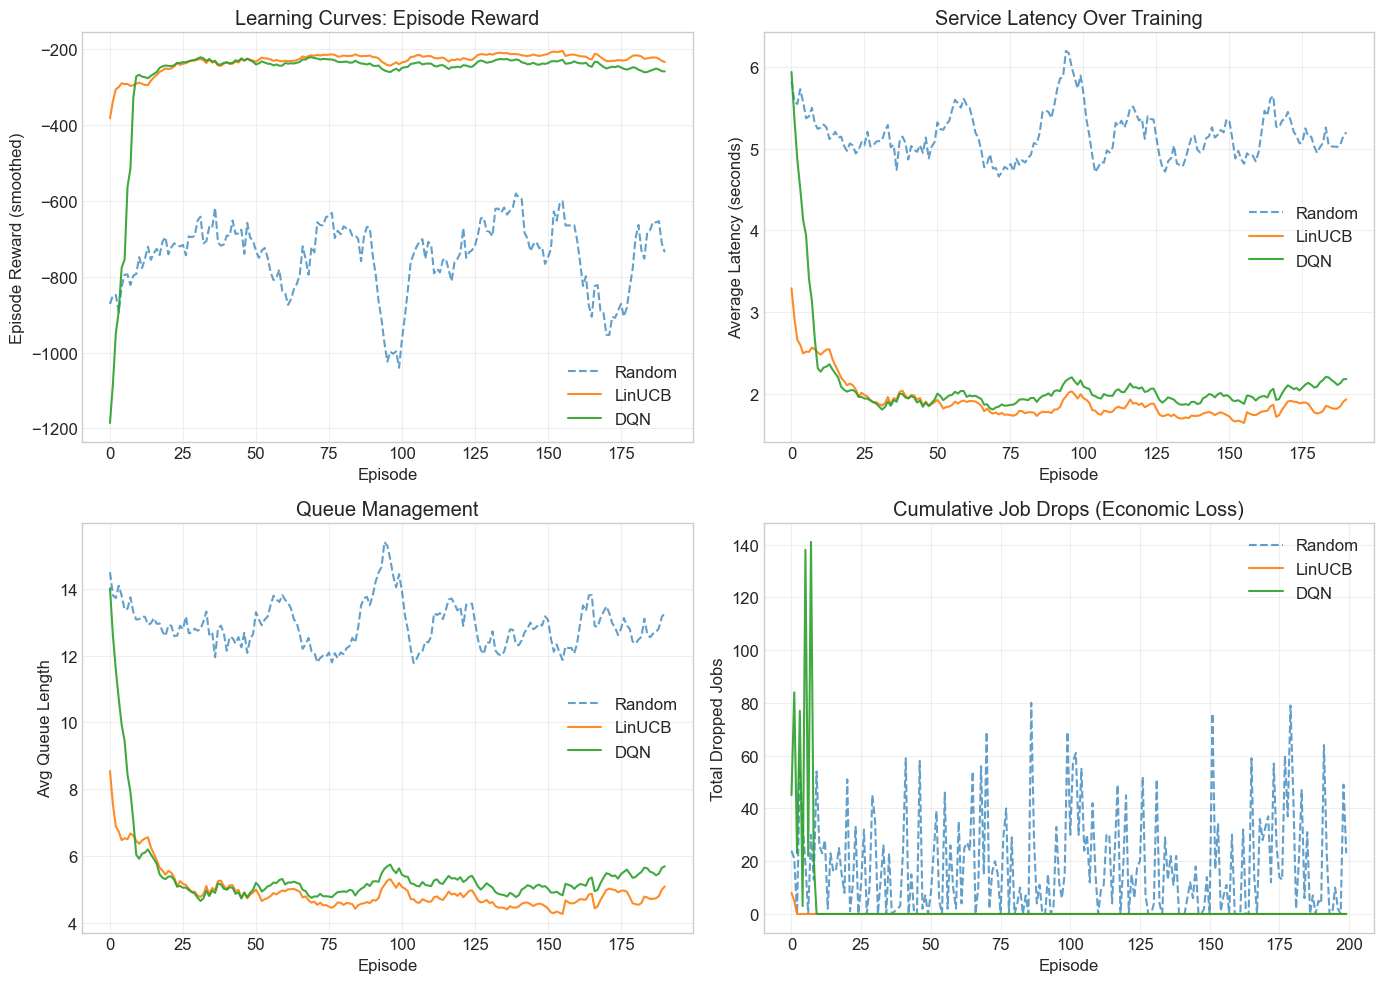

In [22]:
def smooth(data, window=10):
    """Compute moving average."""
    kernel = np.ones(window) / window
    return np.convolve(data, kernel, mode='valid')

# Plot learning curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Episode Rewards
ax = axes[0, 0]
ax.plot(smooth(random_history['episode_rewards'], 10), label='Random', alpha=0.7, linestyle='--')
ax.plot(smooth(linucb_history['episode_rewards'], 10), label='LinUCB', alpha=0.9)
ax.plot(smooth(dqn_history['episode_rewards'], 10), label='DQN', alpha=0.9)
ax.set_xlabel('Episode')
ax.set_ylabel('Episode Reward (smoothed)')
ax.set_title('Learning Curves: Episode Reward')
ax.legend()
ax.grid(True, alpha=0.3)

# Average Latency
ax = axes[0, 1]
ax.plot(smooth(random_history['avg_latencies'], 10), label='Random', alpha=0.7, linestyle='--')
ax.plot(smooth(linucb_history['avg_latencies'], 10), label='LinUCB', alpha=0.9)
ax.plot(smooth(dqn_history['avg_latencies'], 10), label='DQN', alpha=0.9)
ax.set_xlabel('Episode')
ax.set_ylabel('Average Latency (seconds)')
ax.set_title('Service Latency Over Training')
ax.legend()
ax.grid(True, alpha=0.3)

# Queue Lengths
ax = axes[1, 0]
ax.plot(smooth(random_history['queue_lengths'], 10), label='Random', alpha=0.7, linestyle='--')
ax.plot(smooth(linucb_history['queue_lengths'], 10), label='LinUCB', alpha=0.9)
ax.plot(smooth(dqn_history['queue_lengths'], 10), label='DQN', alpha=0.9)
ax.set_xlabel('Episode')
ax.set_ylabel('Avg Queue Length')
ax.set_title('Queue Management')
ax.legend()
ax.grid(True, alpha=0.3)

# Cumulative Drops
ax = axes[1, 1]
ax.plot(random_history['total_drops'], label='Random', alpha=0.7, linestyle='--')
ax.plot(linucb_history['total_drops'], label='LinUCB', alpha=0.9)
ax.plot(dqn_history['total_drops'], label='DQN', alpha=0.9)
ax.set_xlabel('Episode')
ax.set_ylabel('Total Dropped Jobs')
ax.set_title('Cumulative Job Drops (Economic Loss)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../logs/learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Performance Summary

In [23]:
def compute_stats(history, last_n=50):
    """Compute summary statistics from last N episodes."""
    return {
        'avg_reward': np.mean(history['episode_rewards'][-last_n:]),
        'std_reward': np.std(history['episode_rewards'][-last_n:]),
        'avg_latency': np.mean(history['avg_latencies'][-last_n:]),
        'avg_queue': np.mean(history['queue_lengths'][-last_n:]),
        'total_drops': history['total_drops'][-1],
    }

random_stats = compute_stats(random_history)
linucb_stats = compute_stats(linucb_history)
dqn_stats = compute_stats(dqn_history)

print("\n" + "="*70)
print("PERFORMANCE SUMMARY (Last 50 Episodes)")
print("="*70)
print(f"{'Metric':<20} {'Random':>15} {'LinUCB':>15} {'DQN':>15}")
print("-"*70)
print(f"{'Avg Reward':<20} {random_stats['avg_reward']:>15.2f} {linucb_stats['avg_reward']:>15.2f} {dqn_stats['avg_reward']:>15.2f}")
print(f"{'Reward Std':<20} {random_stats['std_reward']:>15.2f} {linucb_stats['std_reward']:>15.2f} {dqn_stats['std_reward']:>15.2f}")
print(f"{'Avg Latency (s)':<20} {random_stats['avg_latency']:>15.3f} {linucb_stats['avg_latency']:>15.3f} {dqn_stats['avg_latency']:>15.3f}")
print(f"{'Avg Queue Length':<20} {random_stats['avg_queue']:>15.2f} {linucb_stats['avg_queue']:>15.2f} {dqn_stats['avg_queue']:>15.2f}")
print(f"{'Total Drops':<20} {random_stats['total_drops']:>15d} {linucb_stats['total_drops']:>15d} {dqn_stats['total_drops']:>15d}")
print("="*70)


PERFORMANCE SUMMARY (Last 50 Episodes)
Metric                        Random          LinUCB             DQN
----------------------------------------------------------------------
Avg Reward                   -767.55         -221.65         -245.78
Reward Std                    283.89           30.30           30.78
Avg Latency (s)                5.178           1.817           2.059
Avg Queue Length               12.92            4.74            5.33
Total Drops                       23               0               0


## 8. Economic Loss Analysis

Calculate the economic impact of job drops and latency.

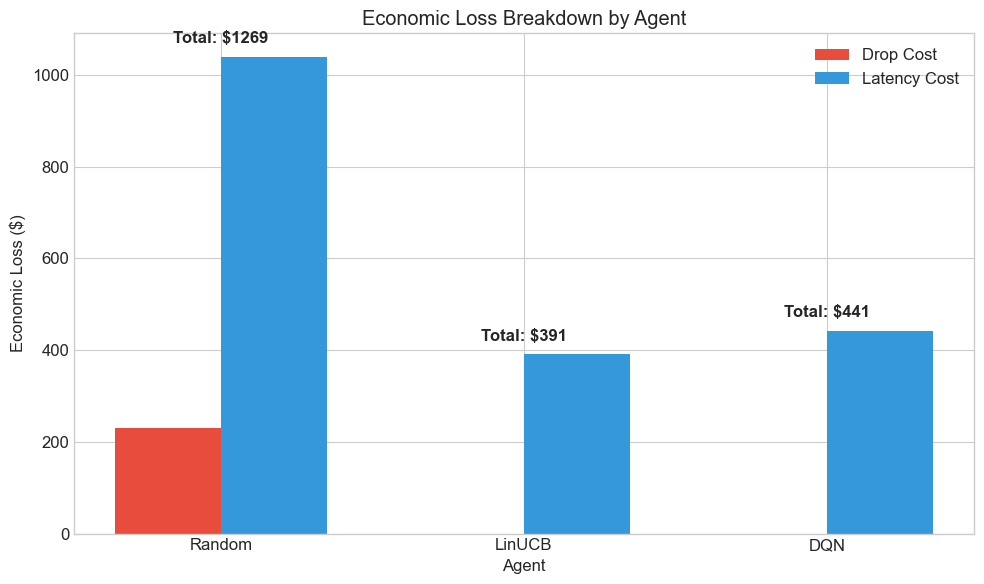


Economic Loss Summary:
  Random: $1268.61
  LinUCB: $390.52 (savings: $878.08)
  DQN:    $440.78 (savings: $827.83)


In [24]:
# Economic parameters
COST_PER_DROP = 10.0      # $ per dropped job
COST_PER_LATENCY_SEC = 1.0  # $ per second of latency

def compute_economic_loss(history, config):
    """Compute total economic loss."""
    drop_cost = history['total_drops'][-1] * COST_PER_DROP
    latency_cost = sum(history['avg_latencies']) * COST_PER_LATENCY_SEC
    return drop_cost, latency_cost, drop_cost + latency_cost

# Compute losses
random_loss = compute_economic_loss(random_history, config)
linucb_loss = compute_economic_loss(linucb_history, config)
dqn_loss = compute_economic_loss(dqn_history, config)

# Plot economic losses
fig, ax = plt.subplots(figsize=(10, 6))

agents = ['Random', 'LinUCB', 'DQN']
drop_costs = [random_loss[0], linucb_loss[0], dqn_loss[0]]
latency_costs = [random_loss[1], linucb_loss[1], dqn_loss[1]]

x = np.arange(len(agents))
width = 0.35

bars1 = ax.bar(x - width/2, drop_costs, width, label='Drop Cost', color='#e74c3c')
bars2 = ax.bar(x + width/2, latency_costs, width, label='Latency Cost', color='#3498db')

ax.set_xlabel('Agent')
ax.set_ylabel('Economic Loss ($)')
ax.set_title('Economic Loss Breakdown by Agent')
ax.set_xticks(x)
ax.set_xticklabels(agents)
ax.legend()

# Add total labels
for i, (d, l) in enumerate(zip(drop_costs, latency_costs)):
    ax.annotate(f'Total: ${d+l:.0f}', xy=(i, max(d, l)), 
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../logs/economic_loss.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nEconomic Loss Summary:")
print(f"  Random: ${random_loss[2]:.2f}")
print(f"  LinUCB: ${linucb_loss[2]:.2f} (savings: ${random_loss[2] - linucb_loss[2]:.2f})")
print(f"  DQN:    ${dqn_loss[2]:.2f} (savings: ${random_loss[2] - dqn_loss[2]:.2f})")

## 9. Agent Behavior Visualization

Visualize how each agent distributes load across servers.

In [25]:
def analyze_routing(agent, env, n_steps=500, seed=42):
    """Analyze agent routing behavior."""
    env.reset(seed=seed)
    actions = []
    states = []
    
    state = env.reset()
    for _ in range(n_steps):
        action = agent.select_action(state, explore=False)  # Greedy
        actions.append(action)
        states.append(state.copy())
        state, _, done, _ = env.step(action)
        if done:
            state = env.reset()
    
    return np.array(actions), np.array(states)

# Analyze routing for each agent
random_actions, _ = analyze_routing(random_agent, env)
linucb_actions, linucb_states = analyze_routing(linucb_agent, env)
dqn_actions, dqn_states = analyze_routing(dqn_agent, env)

# Plot action distributions
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, actions, title in zip(axes, 
                               [random_actions, linucb_actions, dqn_actions],
                               ['Random', 'LinUCB', 'DQN']):
    counts = np.bincount(actions, minlength=4)
    ax.bar(range(4), counts, color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6'])
    ax.set_xlabel('Server ID')
    ax.set_ylabel('Times Selected')
    ax.set_title(f'{title} - Routing Distribution')
    ax.set_xticks(range(4))

plt.tight_layout()
plt.savefig('../logs/routing_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

TypeError: RandomAgent.select_action() got an unexpected keyword argument 'explore'

## 10. Conclusions

### Key Findings:

1. **Learning Progress**: Both LinUCB and DQN show improvement over the random baseline.

2. **LinUCB**: Quick adaptation due to online learning, good for simpler routing patterns.

3. **DQN**: Better long-term performance due to temporal credit assignment, but requires more samples.

4. **Economic Impact**: Trained agents significantly reduce job drops and latency costs.

In [ ]:
print("\n" + "="*50)
print("Notebook execution complete!")
print("="*50)


Notebook execution complete!
